<Axes: >

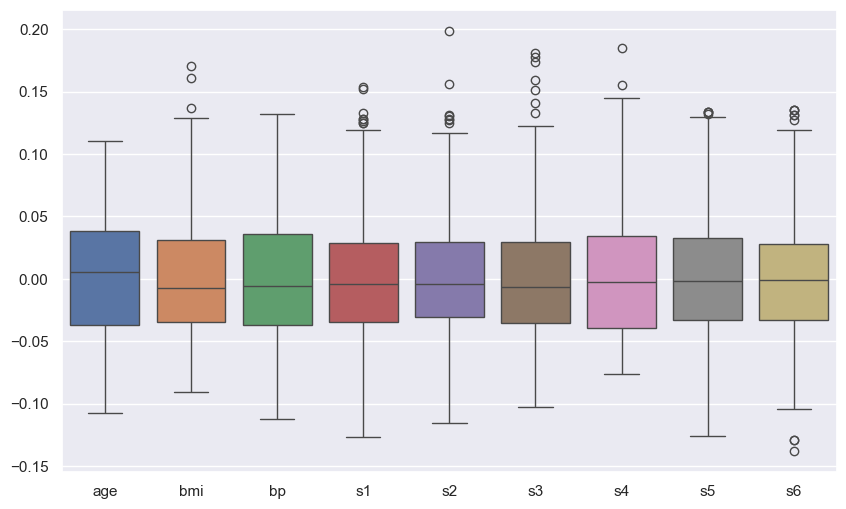

In [1]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

X, y = datasets.load_diabetes(as_frame=True, return_X_y=True)

sns.set_theme(rc={'figure.figsize': (10,6)})

sns.boxplot(data=X.drop(columns='sex'))

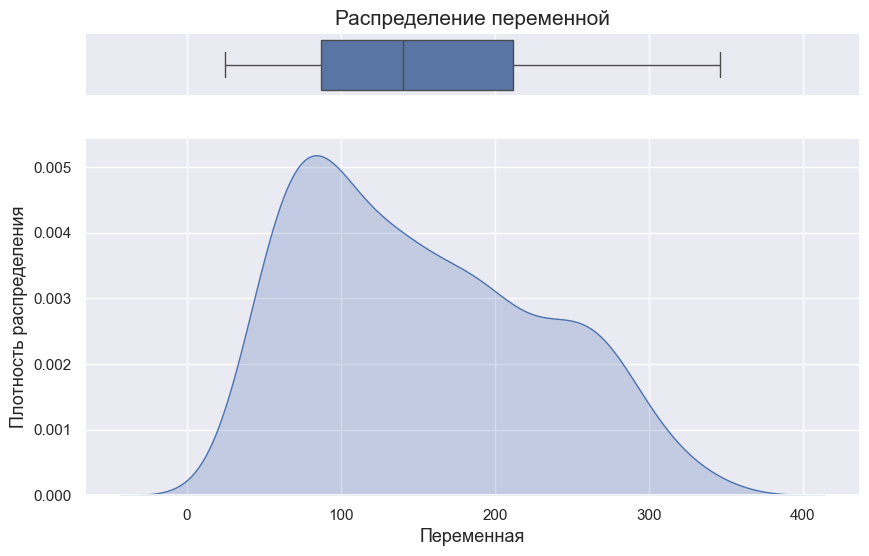

In [2]:
f, (ax_box, ax_kde) = plt.subplots(nrows = 2, # из двух строк
                                    ncols = 1, # и одного столбца
                                    sharex = True, # оставим только нижние подписи к оси x
                                    gridspec_kw = {'height_ratios': (.15, .85)}) # зададим разную высоту строк

# в первом подграфике построим boxplot
sns.boxplot(x = y, ax = ax_box)
ax_box.set(xlabel = None)
# во втором - график плотности распределения
sns.kdeplot(y, fill = True)

# зададим заголовок и подписи к осям
ax_box.set_title('Распределение переменной', fontsize = 15)
ax_kde.set_xlabel('Переменная', fontsize = 13)
ax_kde.set_ylabel('Плотность распределения', fontsize = 13)
 
plt.show()

In [3]:
data = pd.merge(X, y, left_index=True, right_index=True)

st, p = stats.pointbiserialr(X.sex, y)
print(st)

data.corr().target.to_frame().style.background_gradient()

0.04306199845160541


,target
age,0.187889
sex,0.043062
bmi,0.586450
bp,0.441482
s1,0.212022
s2,0.174054
s3,-0.394789
s4,0.430453
s5,0.565883
s6,0.382483


In [4]:
data.isnull().sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

In [5]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest()
clf.fit(data)

data['anomaly'] = clf.predict(data)
data = data[data.anomaly == 1]
data = data.drop(columns='anomaly')
data.shape


(372, 11)

MSE = 2818.8501863642846
RMSE = 53.09284496393355
MAE = 42.96234500069079
MAPE = 0.39235872594414833
R2 = 0.45336845359973554


<Axes: xlabel='bmi', ylabel='target'>

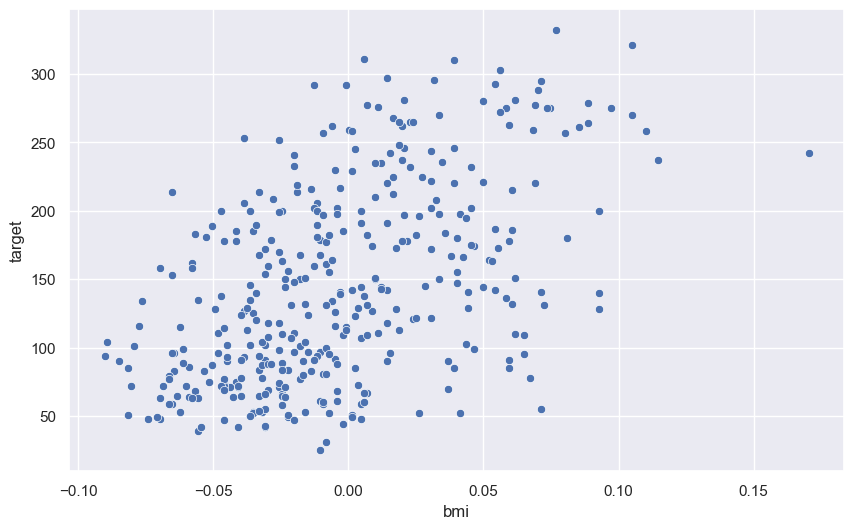

In [16]:
X = data.drop('target', axis=1)
y = data['target']

from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

model = LinearRegression()
y_pred = model.fit(X, y).predict(X)

MSE = metrics.mean_squared_error(y, y_pred) # среднеквадратичная ошибка
RMSE = metrics.root_mean_squared_error(y, y_pred) # корень среднеквадратичной ошибки
MAE = metrics.mean_absolute_error(y, y_pred) # средняя абсолютная ошибка (между предсказанным и истинным значением)
MAPE = metrics.mean_absolute_percentage_error(y, y_pred) # средняя абсолютная ошибка в процентах
R2 = metrics.r2_score(y, y_pred)

print(f'MSE = {MSE}\nRMSE = {RMSE}\nMAE = {MAE}\nMAPE = {MAPE}\nR2 = {R2}')

sns.scatterplot(x=X['bmi'], y=y)

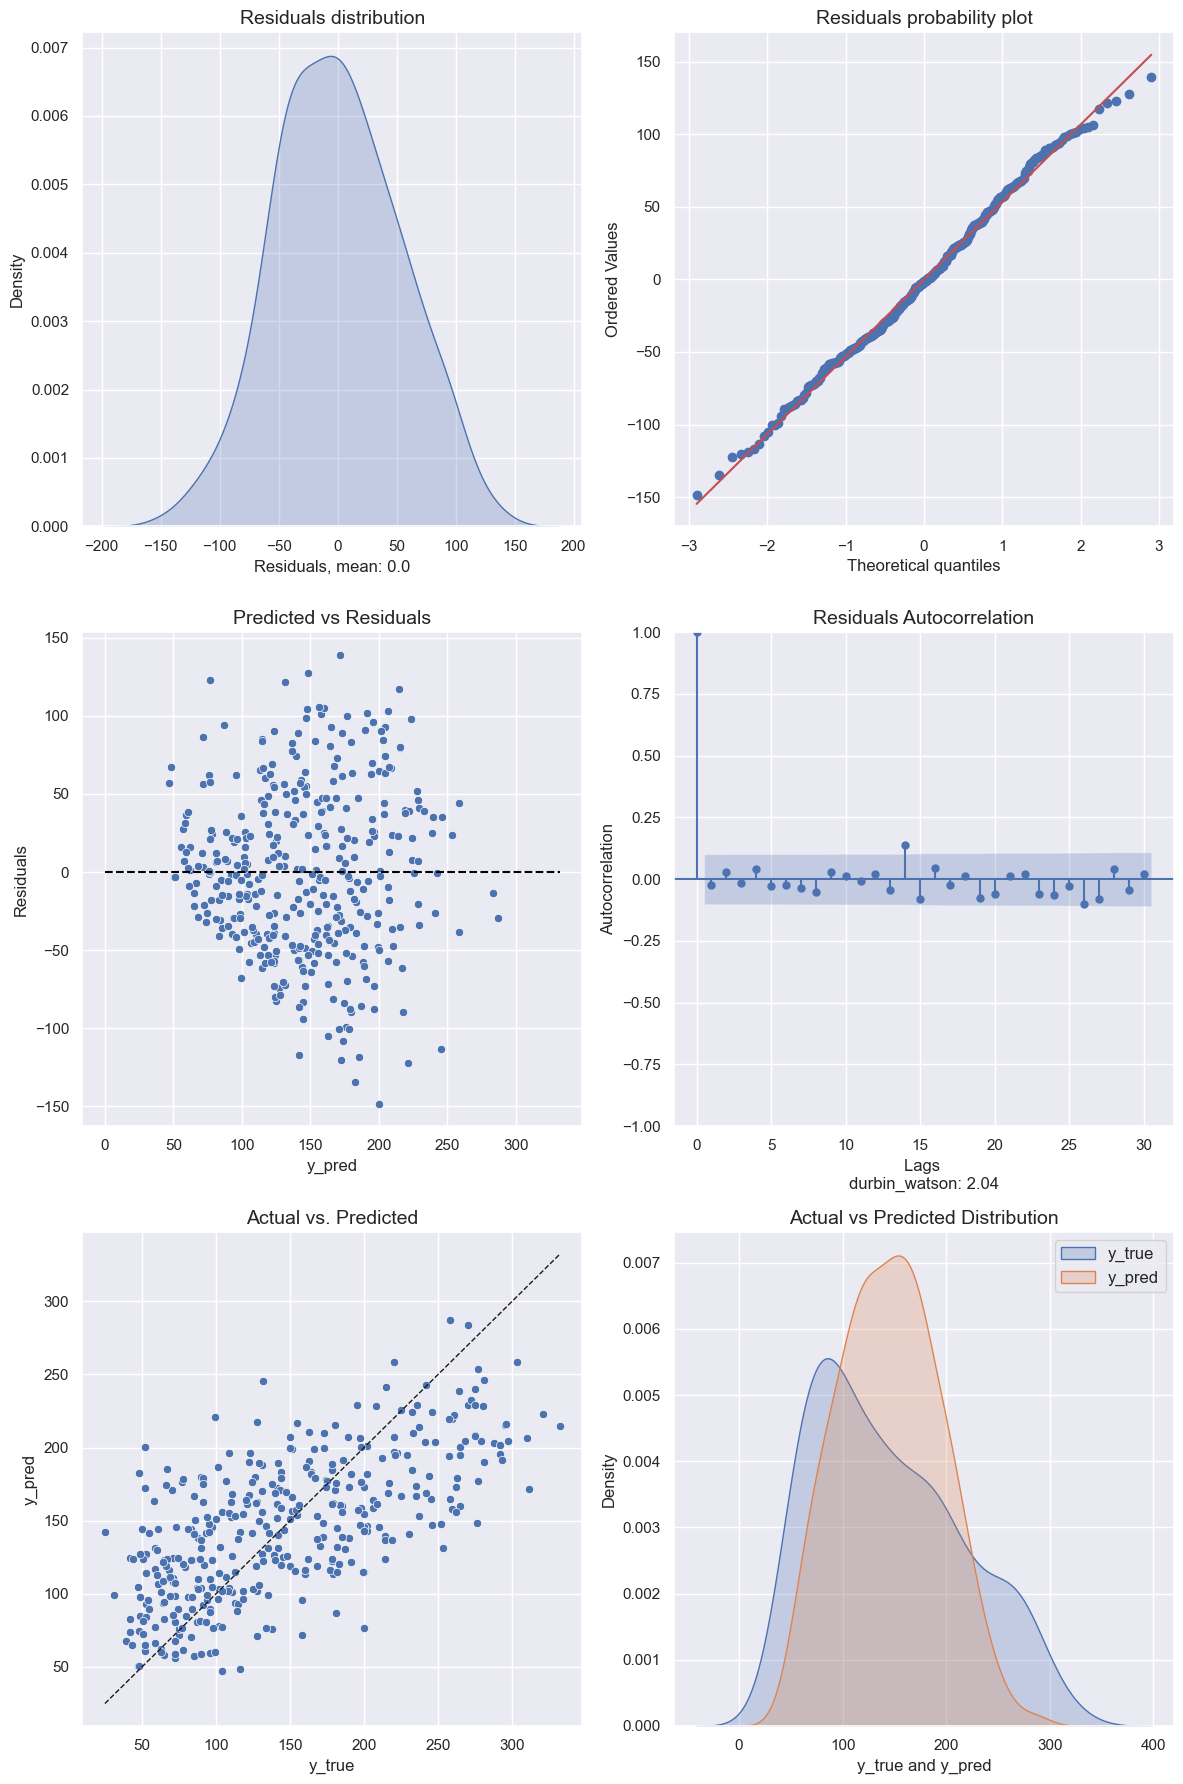

In [7]:
from user_modules.diag_LR_model import diagnostics_LR_model

diagnostics_LR_model(y, y_pred)

In [8]:
'''
расчет коэффициента инфляции дисперсии VIF для обнаружения степени
мультиколлинеарности в MLR
'''

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

c = add_constant(X.drop('sex', axis=1))

VIFs = pd.DataFrame()
VIFs['Variable'] = c.columns
VIFs['VIF'] = [variance_inflation_factor(c.values, i) for i in range(c.shape[1])]
VIFs

c = add_constant(X.drop(['sex', 's1'], axis=1)) # удалим признак с наибольшим VIF

VIFs = pd.DataFrame()
VIFs['Variable'] = c.columns
VIFs['VIF'] = [variance_inflation_factor(c.values, i) for i in range(c.shape[1])]
VIFs

,Variable,VIF
0,const,1.063605
1,age,1.236730
2,bmi,1.366095
3,bp,1.350171
4,s2,3.153109
5,s3,4.386835
6,s4,8.519702
7,s5,1.927165
8,s6,1.373556


In [9]:
data = data.drop('s1', axis=1)

In [10]:
from sklearn.preprocessing import PowerTransformer
 
pt = PowerTransformer()
new_data = pd.DataFrame(pt.fit_transform(data),
                      columns = data.columns)

new_data.head()

,age,sex,bmi,bp,s2,s3,s4,s5,s6,target
0,0.747933,1.090062,1.437522,0.592810,-0.844855,-1.080819,0.157396,0.598527,-0.341932,0.254628
1,-0.155182,-0.917379,-1.195480,-0.493224,-0.422829,1.589946,-0.911095,-1.572977,-2.070808,-1.004380
2,1.939744,1.090062,1.124606,-0.008937,-0.827666,-0.762785,0.157396,0.203051,-0.532200,0.119870
3,-1.831574,-0.917379,-0.095661,-0.746429,0.683650,-0.866988,1.023154,0.661988,-0.152130,0.899665
4,0.002137,-0.917379,-0.753957,0.592810,0.458185,0.271397,0.157396,-0.640880,-1.009891,0.035709


In [11]:
new_data.drop(columns='sex').corr().target.to_frame().style.background_gradient()

,target
age,0.208433
bmi,0.505936
bp,0.382366
s2,0.168208
s3,-0.383495
s4,0.418549
s5,0.531537
s6,0.308465
target,1.000000


In [12]:
st, p = stats.pointbiserialr(new_data.sex, new_data.target)
print(st)

0.011828541937334796


In [13]:
X = new_data.drop(columns=['age', 'sex', 'bp', 's2', 's3', 's4', 's6', 'target'])
y = new_data.target

from sklearn.linear_model import LinearRegression
 
model = LinearRegression()
y_pred = model.fit(X, y).predict(X)

MAPE = metrics.mean_absolute_percentage_error(y, y_pred) # средняя абсолютная ошибка в процентах
R2 = metrics.r2_score(y, y_pred)

print(f'MAPE = {MAPE}\nR2 = {R2}')

MAPE = 2.2866121403514854
R2 = 0.37802333641585095


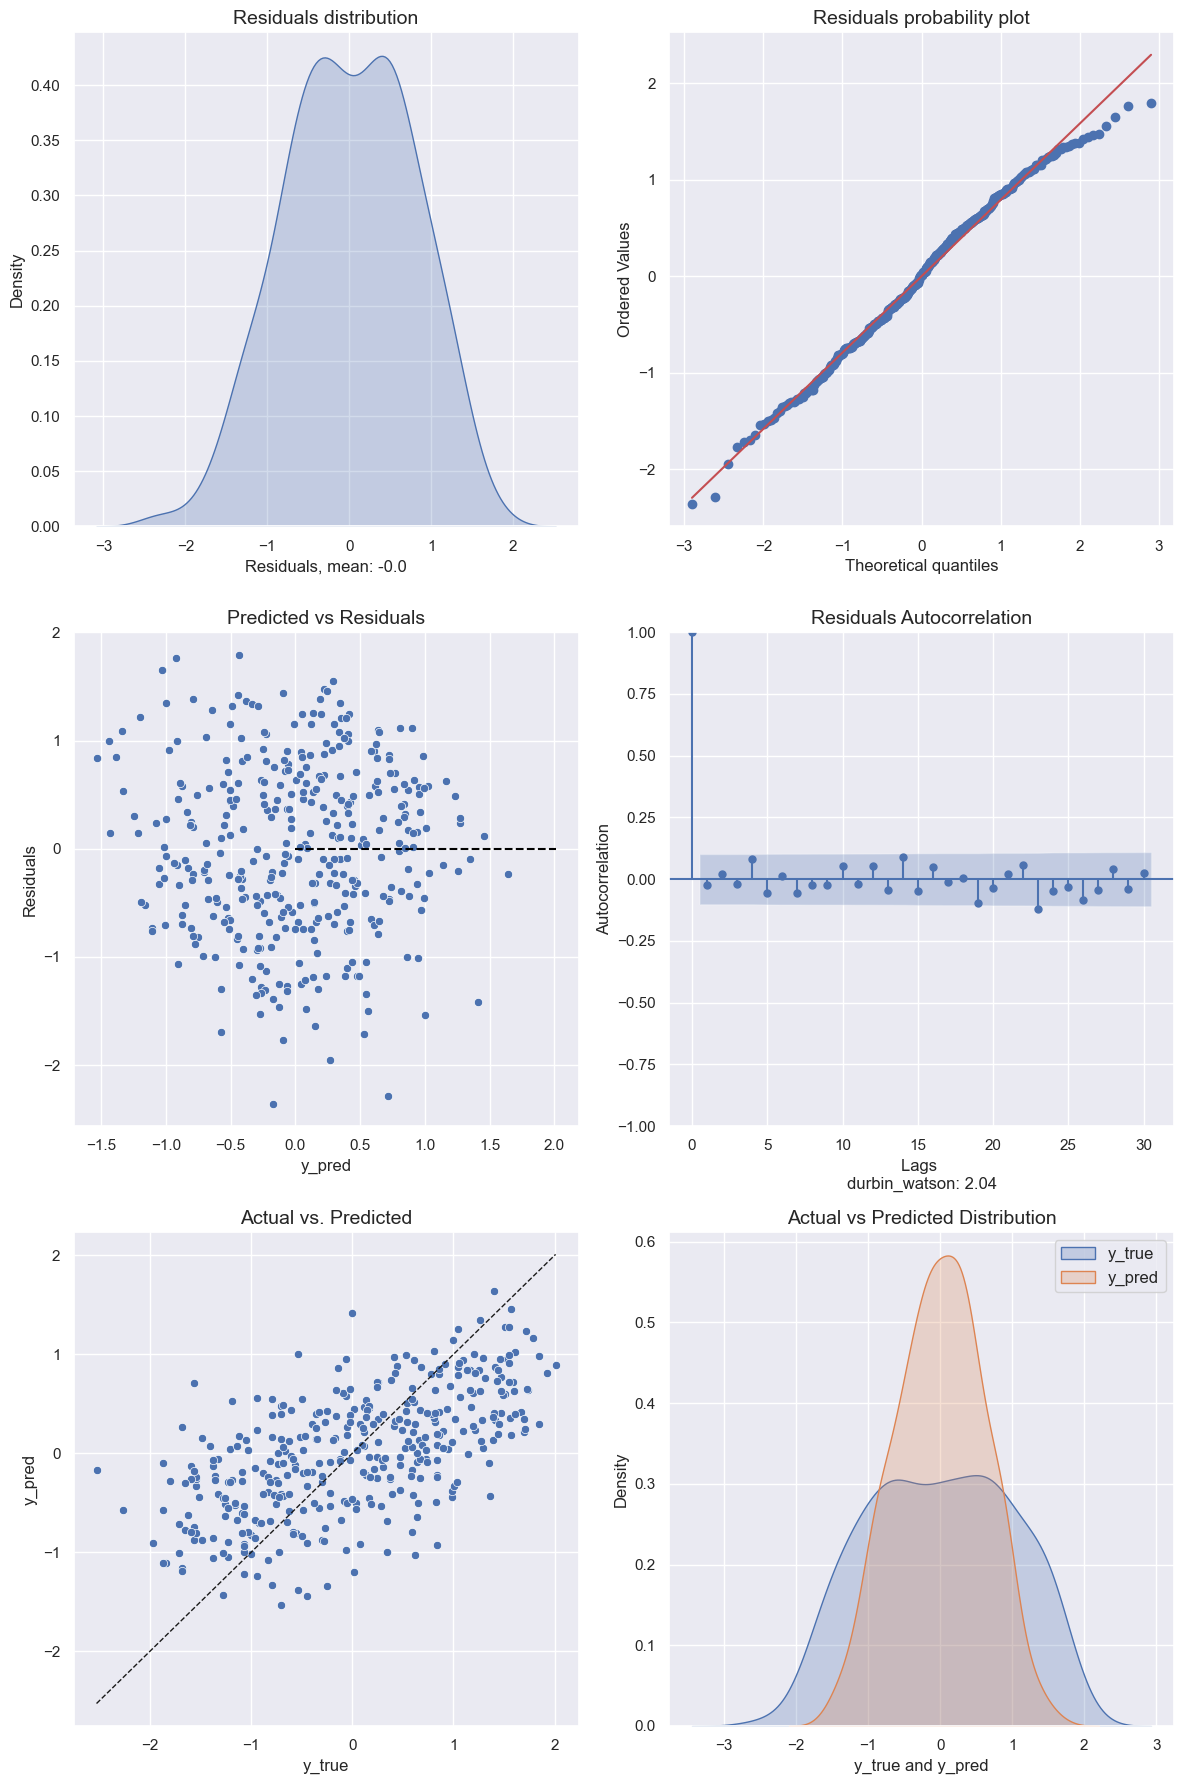

In [14]:
diagnostics_LR_model(y, y_pred)